In [1]:
import sys
sys.path.insert(0, "../../")

In [7]:
import tensorflow as tf
from tensorflow_probability import edward2 as ed
from keras.layers import Dense, Activation
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
import inferpy as inf
from inferpy.data import mnist
import pandas as pd
import sys

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

import warnings
warnings.filterwarnings("ignore")

# Global configuration
num_epochs = 3000
tf.reset_default_graph()
tf.set_random_seed(1234)
verbose = True
learning_rate = 0.01

## Data 

For illustrating purposes, the MNIST dataset containg handwritten digits will be used. In particular we might obtain the data from the ``inferpy`` package (and hence from keras):

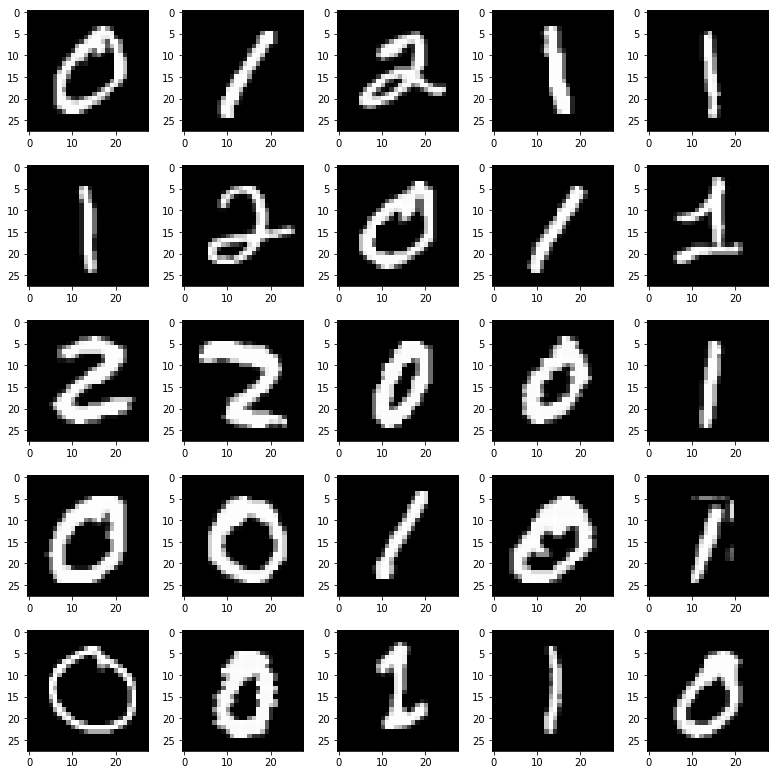

In [3]:
# number of observations (dataset size)
N = 1000
# digits considered
DIG = [0,1,2]

# load the data
(x_train, y_train), _ = mnist.load_data(num_instances=N, digits=DIG)

# plot the digits
mnist.plot_digits(x_train, grid=[5,5])

### Model definition

The implementation for the generative model for a NLPCA model (Algorithm 3) is defined below. The input parameters are: `k` is the latent dimension, `d` is the data-dimension and `N`the number of samples or data instances. 

In [10]:
# Model constants
k, d0, d1 = 2, 100, np.shape(x_train)[-1]

# initial values
loc_init = 0.001
scale_init = 1

@inf.probmodel
def nlpca(k, d0, d1, decoder):

    with inf.datamodel():
        # Define local latent variables
        z = inf.Normal(loc=tf.ones([k]), scale=1, name="z")

        output = decoder(k, d0, d1, z)

        # Define the observed variables
        x = inf.Normal(loc=output, scale=1., name="x")


def decoder(k, d0, d1, z):
    """
    beta0 = inf.Normal(tf.ones([k, d0]) * loc_init, scale_init, name="beta0")
    alpha0 = inf.Normal(tf.ones([d0]) * loc_init, scale_init, name="alpha0")
    
    ######

    beta1 = inf.Normal(tf.ones([d0, d1]) * loc_init, scale_init, name="beta1")
    alpha1 = inf.Normal(tf.ones([d1]) * loc_init, scale_init, name="alpha1")
    
    h0 = tf.nn.relu(z @ beta0 + alpha0, name="h0")

    return h0 @ beta1 + alpha1
    """
    return inf.layers.Sequential([
        tfp.layers.DenseFlipout(d0, input_shape=(k,)),
        tfp.layers.DenseFlipout(d1, activation=tf.nn.relu),
    ])(tf.convert_to_tensor(z))

print(nlpca)
print(decoder)

<function nlpca at 0x139a54a60>
<function decoder at 0x139a548c8>


This is a latent varable model (LVM) containing DNNs where the latent representation $\boldsymbol{z}$ is known as the scores, and the affine transformation is performed using a DNN parametrized by $\boldsymbol{\beta}$ and $\boldsymbol{\alpha}$.

### Inference

Variational inference is a deterministic technique that finds a tractable approximation to an intractable (posterior) distribution. 
We will use $q$ to denote the approximation, and use $p$ to signify the true distribution (like $p(\boldsymbol{\beta, \alpha},\boldsymbol{z}|\boldsymbol{x})$ in the example above).
More specifically, ${\cal Q}$ will denote a set of possible approximations $q$.

In practice, we define a generative model for sampling from $q(\boldsymbol{\beta, \alpha},\boldsymbol{z} | \boldsymbol{\lambda}, \boldsymbol{\phi})$, where $\boldsymbol{\lambda}, \boldsymbol{\phi}$ are the variational parameters to optimise.





In [11]:
@inf.probmodel
def Q(k, d0, d1):

    with inf.datamodel():
        qz_loc = inf.Parameter(tf.ones([k]), name="qz_loc")
        qz_scale = tf.math.softplus(inf.Parameter(tf.ones([k]), name="qz_scale"))
        qz = inf.Normal(loc=qz_loc, scale=qz_scale, name="z")

    ###

    qbeta0_loc = inf.Parameter(tf.ones([k, d0]) * loc_init, name="qbeta0_loc")
    qbeta0_scale = tf.math.softplus(inf.Parameter(tf.ones([k, d0]) * scale_init, name="qbeta0_scale"))
    qbeta0 = inf.Normal(qbeta0_loc, qbeta0_scale, name="beta0")

    qalpha0_loc = inf.Parameter(tf.ones([d0]) * loc_init, name="qalpha0_loc")
    qalpha0_scale = tf.math.softplus(inf.Parameter(tf.ones([d0]) * scale_init, name="qalpha0_scale"))
    qalpha0 = inf.Normal(qalpha0_loc, qalpha0_scale, name="alpha0")

    ###

    qbeta1_loc = inf.Parameter(tf.ones([d0, d1]) * loc_init, name="qbeta1_loc")
    qbeta1_scale = tf.math.softplus(inf.Parameter(tf.ones([d0, d1]) * scale_init, name="qbeta1_scale"))
    qbeta1 = inf.Normal(qbeta1_loc, qbeta1_scale, name="beta1")

    qalpha1_loc = inf.Parameter(tf.ones([d1]) * loc_init, name="qalpha1_loc")
    qalpha1_scale = tf.math.softplus(inf.Parameter(tf.ones([d1]) * scale_init, name="qalpha1_scale"))
    qalpha1 = inf.Normal(qalpha1_loc, qalpha1_scale, name="alpha1")

    ###


print(Q)

<function Q at 0x139a54ae8>


Variational methods adjusts the parameters by maximizing the ELBO (Evidence LOwer Bound) denoted $\cal{L}$ and expressed as 

$\cal{L}(\boldsymbol{\lambda},\boldsymbol{\phi})  = \mathbb{E}_q [\ln p(\boldsymbol{x}, \boldsymbol{z}, \boldsymbol{\beta, \alpha})] - \mathbb{E}_q [\ln q(\boldsymbol{\beta, \alpha},\boldsymbol{z}|\boldsymbol{\lambda},\boldsymbol{\phi})]$

In InferPy, this is transparent to the user: it is only required to create the instances of the P and Q models, the optimizer and inference method objects.

In [12]:
# create an instance of the P model and the Q model
m = nlpca(k, d0, d1, decoder)
q = Q(k,d0,d1)

# load the data
(x_train, y_train), _ = mnist.load_data(num_instances=N, digits=DIG)

optimizer = tf.train.AdamOptimizer(learning_rate)
VI = inf.inference.VI(q, optimizer=optimizer, epochs=2000)

W0106 22:29:13.468554 4637902272 module_wrapper.py:139] From ../../inferpy/models/prob_model.py:63: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0106 22:29:13.504453 4637902272 module_wrapper.py:139] From ../../inferpy/util/tf_graph.py:63: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0106 22:29:13.517802 4637902272 module_wrapper.py:139] From ../../inferpy/util/interceptor.py:142: The name tf.variables_initializer is deprecated. Please use tf.compat.v1.variables_initializer instead.



Finally, the ELBO function is maximized.

In [13]:
m.fit({"x": x_train}, VI)        

W0106 22:29:18.111876 4637902272 deprecation.py:323] From ../../inferpy/util/interceptor.py:34: Variable.load (from tensorflow.python.ops.variables) is deprecated and will be removed in a future version.
Instructions for updating:
Prefer Variable.assign which has equivalent behavior in 2.X.
W0106 22:29:19.886749 4637902272 deprecation.py:323] From /Users/jcozar/dev/almeria/inferPy/InferPy/venv/lib/python3.6/site-packages/tensorflow_core/python/ops/array_ops.py:1475: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0106 22:29:20.733918 4637902272 module_wrapper.py:139] From ../../inferpy/inference/variational/vi.py:187: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.




 0 epochs	 2894917632.0....................
 200 epochs	 1632286080.0....................
 400 epochs	 1360950784.0....................
 600 epochs	 1231647488.0....................
 800 epochs	 1144349952.0....................
 1000 epochs	 1126289280.0....................
 1200 epochs	 1116543360.0....................
 1400 epochs	 1110800256.0....................
 1600 epochs	 1105994880.0....................
 1800 epochs	 1102326144.0....................

After the inference, we can plot the hidden representation:

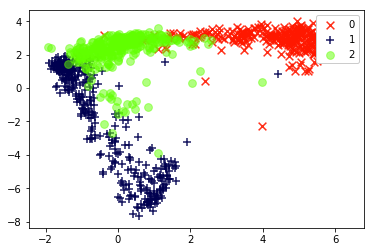

In [14]:
post = {"z": m.posterior("z", data={"x": x_train}).sample()}

markers = ["x", "+", "o"]
colors = [plt.get_cmap("gist_rainbow")(0.05),
          plt.get_cmap("gnuplot2")(0.08),
          plt.get_cmap("gist_rainbow")(0.33)]
transp = [0.9, 0.9, 0.5]

fig = plt.figure()

for c in range(0, len(DIG)):
    col = colors[c]
    plt.scatter(post["z"][y_train == DIG[c], 0], post["z"][y_train == DIG[c], 1], color=col,
                label=DIG[c], marker=markers[c], alpha=transp[c], s=60)
    plt.legend(loc='upper right',framealpha=1)

## Test

For testing our model, we will generate samples of $\boldsymbol{x}$ given the infered posterior distributions.

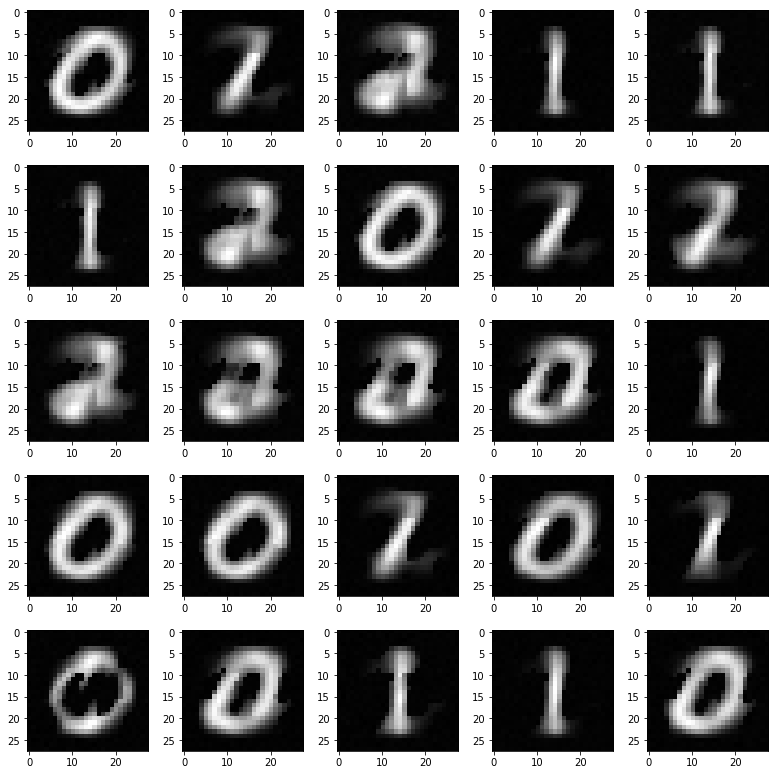

In [15]:
x_gen = m.posterior_predictive('x', data=post).sample()

# plot the digits
mnist.plot_digits(x_gen, grid=[5,5])